In [ ]:
import os
import glob
#from glob import glob
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
import xml.etree.ElementTree as ET
import tensorflow as tf
from keras.models import load_model
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/marmot_256.zip

In [ ]:
#https://github.com/jainammm/TableNet/blob/master/TableNet.pdf
#https://www.tensorflow.org/tutorials/images/segmentation
list_images = tf.data.Dataset.list_files('/content/content/marmot/images/*.jpg')

In [ ]:
def process(file_path):
  img = tf.io.read_file(file_path)
  img = tf.image.decode_jpeg(img)
  column_mask_path = tf.strings.regex_replace(file_path, 'images', 'column_mask')
  column_mask = tf.io.read_file(column_mask_path)
  column_mask = tf.image.decode_jpeg(column_mask)
  column_mask = tf.cast(column_mask, tf.float32)/255.0
  table_mask_path = tf.strings.regex_replace(file_path, 'images', 'table_mask')
  table_mask = tf.io.read_file(table_mask_path)
  table_mask = tf.image.decode_jpeg(table_mask)
  table_mask = tf.cast(table_mask, tf.float32)/255.0
  return img, {'table_mask': table_mask, 'column_mask': column_mask}

In [ ]:
DATA_SIZE = len(list(list_images))
train_size = int(0.9*DATA_SIZE)

train = list_images.take(train_size)
validation = list_images.skip(train_size)

TRAIN_SIZE = len(list(train))
VALIDATION_SIZE = len(list(validation))
BUFFER_SIZE = 1000
BATCH_SIZE = 3
STEPS_PER_EPOCH = TRAIN_SIZE//BATCH_SIZE

train = train.shuffle(BUFFER_SIZE)

In [ ]:
train = train.map(process, num_parallel_calls=tf.data.experimental.AUTOTUNE)
validation = validation.map(process)

In [ ]:
train_data = train.batch(BATCH_SIZE).prefetch(buffer_size=1)
validation_data = validation.batch(BATCH_SIZE).prefetch(buffer_size=1)

In [ ]:
#https://www.tensorflow.org/tutorials/images/segmentation
def display(display_list):
    
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'Table Mask', 'Column Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(256, 256, 3)


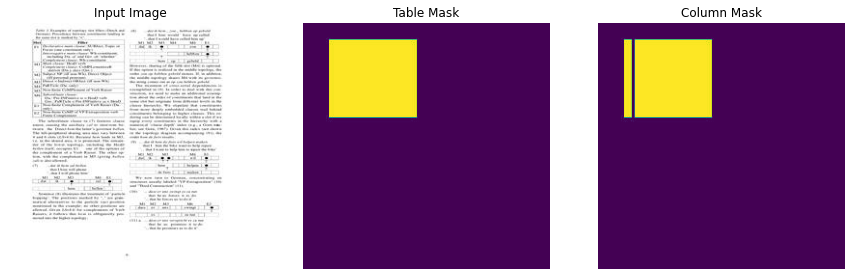

(256, 256, 3)


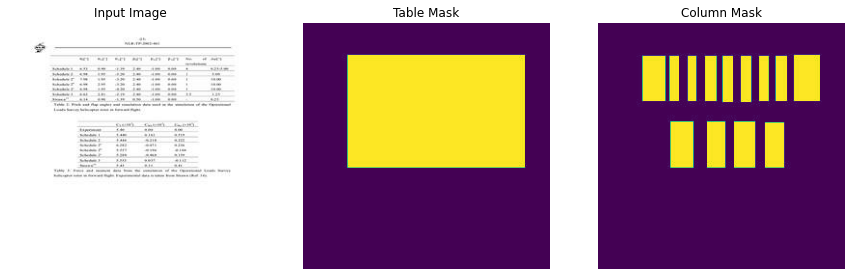

(256, 256, 3)


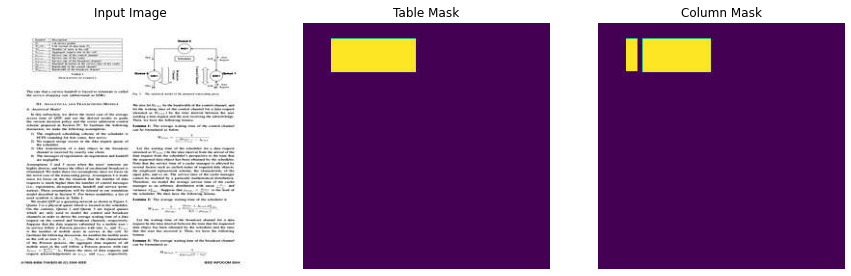

In [ ]:
for image, mask  in train.take(3):
    print(image.shape)
    display([image, mask['table_mask'], mask['column_mask']])

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Dropout, Dense, Flatten, Input, Concatenate, UpSampling2D, Conv2DTranspose

In [ ]:
def table_decoder(x, vgg19_pool3, vgg19_pool4):
  x = Conv2D(512, (1,1), activation = 'relu', name = 'conv7_table')(x)
  x = UpSampling2D((2,2), name = '2xconv7_table')(x)
  x = Concatenate()([x,vgg19_pool4])
  x = UpSampling2D((2,2), name = '2x_pool4_2xconv7_table')(x)
  x = Concatenate()([x, vgg19_pool3])
  x = UpSampling2D(size=(2,2))(x)
  x = UpSampling2D(size=(2,2))(x)
  x =  Conv2DTranspose(3,3, strides= 2 , padding = 'same', name = 'table_mask')(x)
  return x

In [ ]:
def column_decoder(x, vgg19_pool3, vgg19_pool4):
  x = Conv2D(512, (1,1), activation='relu', name = 'conv7_column')(x)
  x = Dropout(0.8)(x)
  x = Conv2D(512, (1,1), activation='relu', name = 'conv8_column')(x)
  x = UpSampling2D((2,2), name = '2xconv8_column')(x)
  x = Concatenate()([x, vgg19_pool4])
  x = UpSampling2D((2,2), name = '2x_pool4_2xconv8_column')(x)
  x = Concatenate()([x, vgg19_pool3])
  x = UpSampling2D(size=(2,2))(x)
  x = UpSampling2D(size=(2,2))(x)
  x =  Conv2DTranspose(3,3, strides=2, padding = 'same', name = 'column_mask')(x)
  return x

In [ ]:
tf.keras.backend.clear_session()
input = Input((256,256,3), name = 'input')
vgg_19 = tf.keras.applications.VGG19(include_top=False, weights = 'imagenet', input_tensor=input)
print(f'VGG19 ouput shape :{vgg_19.output_shape}')
vgg19_pool3 = vgg_19.get_layer('block3_pool').output
print(f'VGG19 pool3 layer output shape : {vgg19_pool3.shape}')
vgg19_pool4 = vgg_19.get_layer('block4_pool').output
print(f'VGG19 pool4 layer output shape : {vgg19_pool4.shape}')

x = Conv2D(512, (1,1), activation='relu', name = 'block6_conv1')(vgg_19.output)
x = Dropout(0.8)(x)
x = Conv2D(512, (1,1), activation='relu', name = 'block6_conv2')(x)
x = Dropout(0.8)(x)
print(f'Shape of encoder output: {x.shape}')

80142336/80134624 [==============================] - 1s 0us/step
VGG19 ouput shape :(None, 8, 8, 512)
VGG19 pool3 layer output shape : (None, 32, 32, 256)
VGG19 pool4 layer output shape : (None, 16, 16, 512)
Shape of encoder output: (None, 8, 8, 512)


In [ ]:
table_mask = table_decoder(x, vgg19_pool3, vgg19_pool4)
column_mask = column_decoder(x, vgg19_pool3, vgg19_pool4)

In [ ]:
model =  Model(inputs = input, outputs = [table_mask, column_mask], name = 'tablenet')

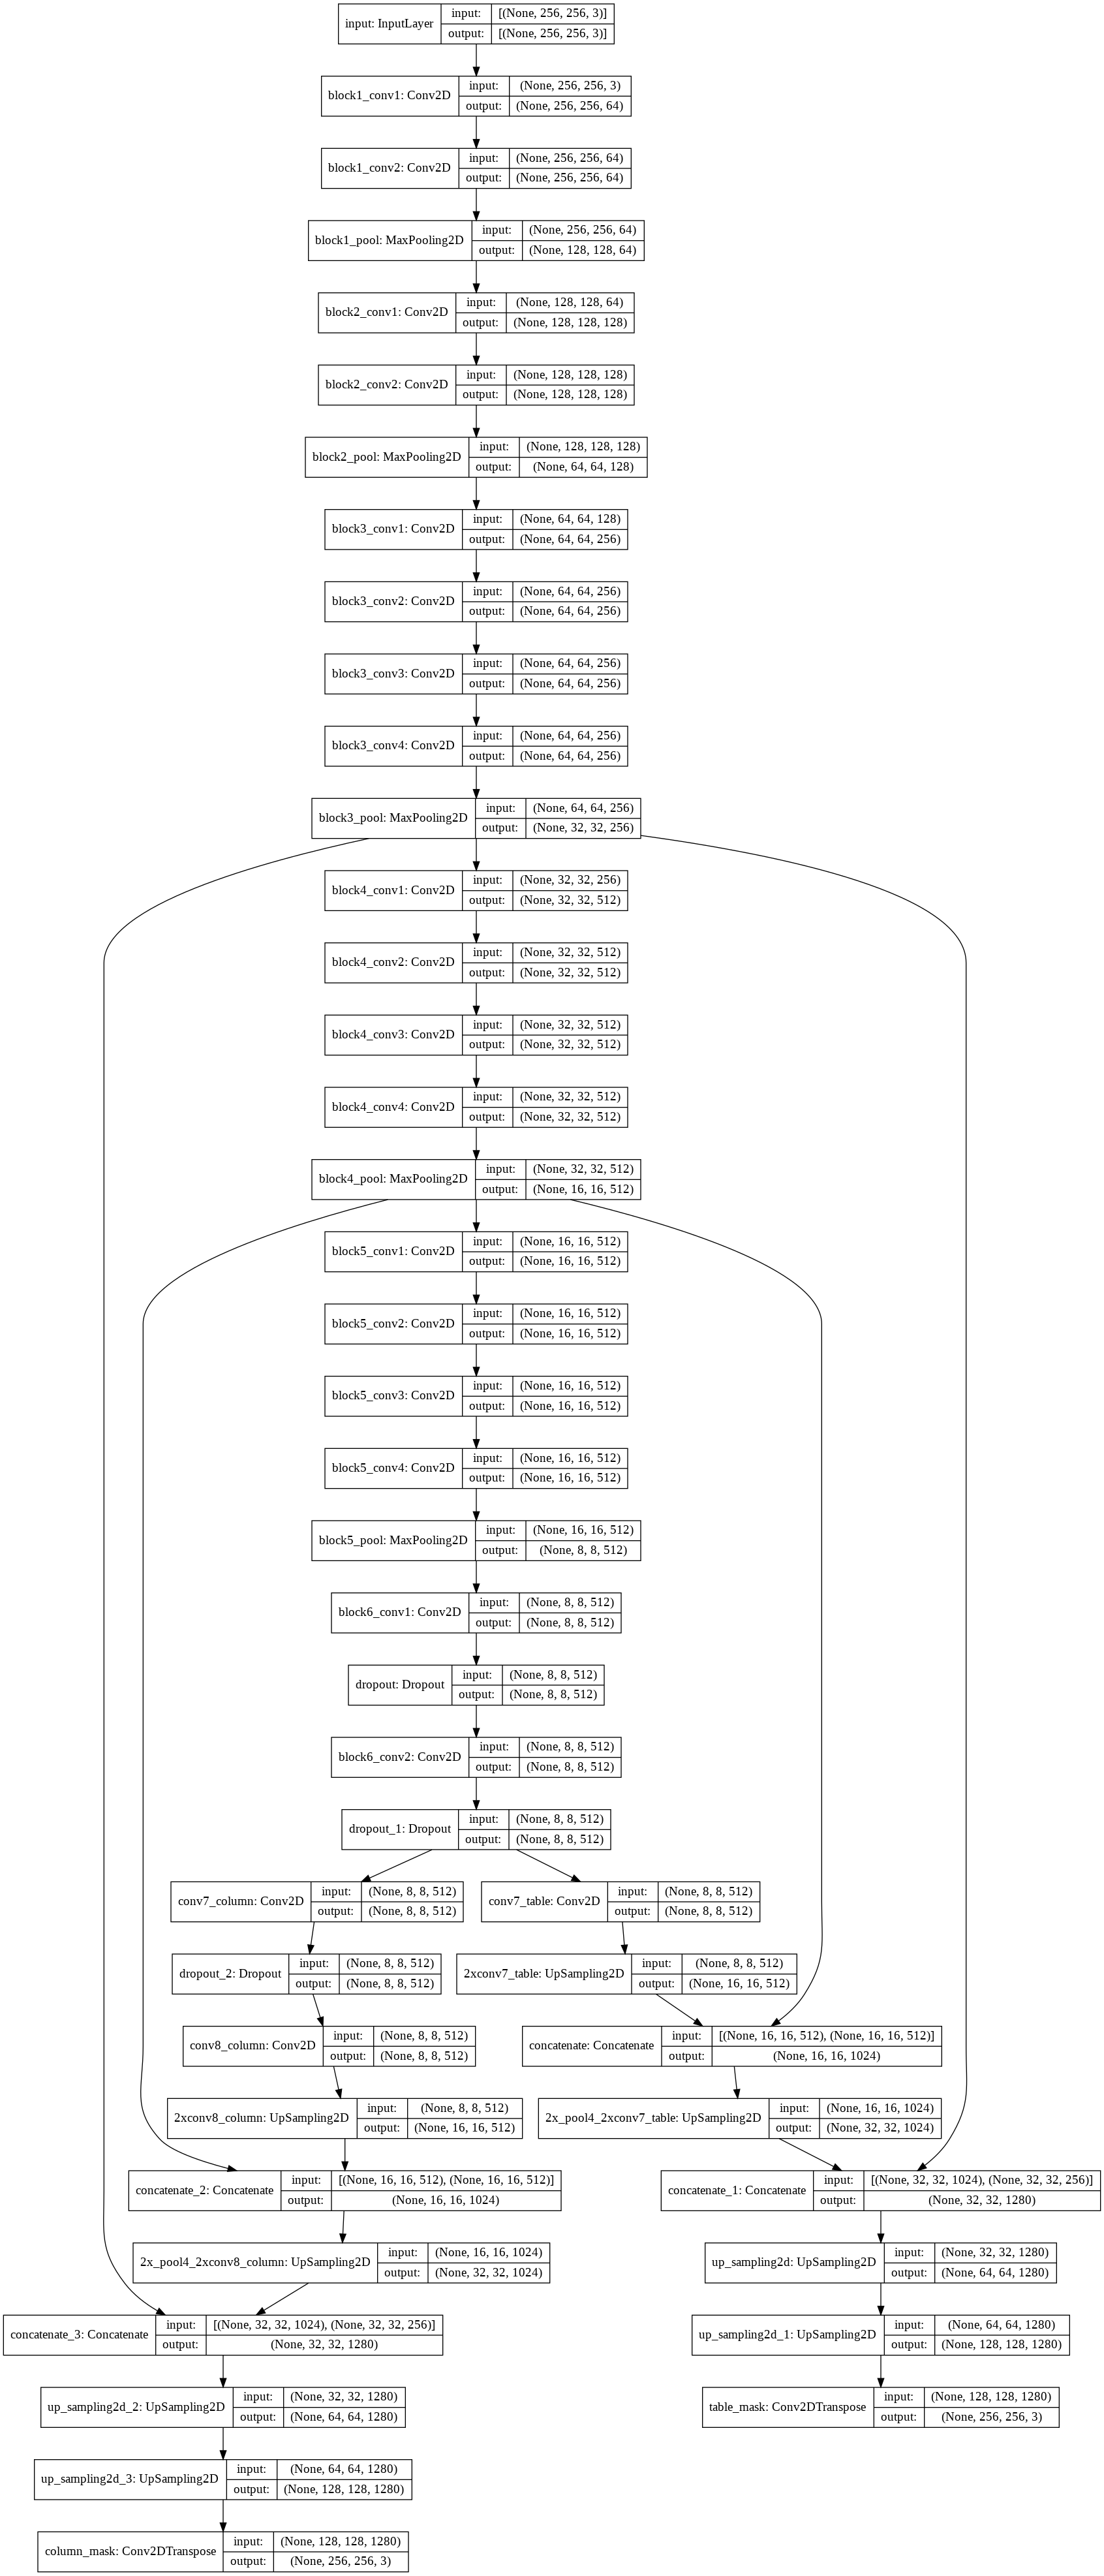

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True,show_layer_names=True)

In [ ]:
losses = {
    "table_mask": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    "column_mask": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
}

lossWeights = {"table_mask": 1.0, "column_mask": 1.0}

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, epsilon=1e-08),
              loss=losses,
              metrics=['accuracy'],
              loss_weights=lossWeights)

In [ ]:
def display_predictions(sample_image):
  for img, (tab_mask, col_mask) in sample_image:
    pred_tabmask, pred_colmask = model.predict(img, verbose=1)
    pred_tabmask = tf.argmax(pred_tabmask, axis=-1)
    pred_tabmask = pred_tabmask[..., tf.newaxis]
    pred_colmask = tf.argmax(pred_colmask, axis=-1)
    pred_colmask = pred_colmask[..., tf.newaxis]
    pred_table_mask = pred_tabmask[0]
    pred_column_mask = pred_colmask[0]
    display([img[0], pred_table_mask, pred_column_mask])

In [ ]:
sample_image = validation_data.take(1)

In [ ]:
class ShowPredictionCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = None):
    if epoch % 10 == 0:
      display_predictions(sample_image)
      print(f'Predicted mask after epoch {epoch+1}') 

In [ ]:
path = os.path.abspath('drive/My Drive/Colab Notebooks')
#os.mkdir(os.path.join(path, 'tablenet_new'))

In [ ]:
path = os.path.join(path, 'tablenet_new')

In [ ]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = os.path.join(path, 'model_{epoch}'), monitor = 'val_loss', save_best_only=True, verbose = 1)

Epoch 1/200
1/1 [==============================] - 0s 469ms/step


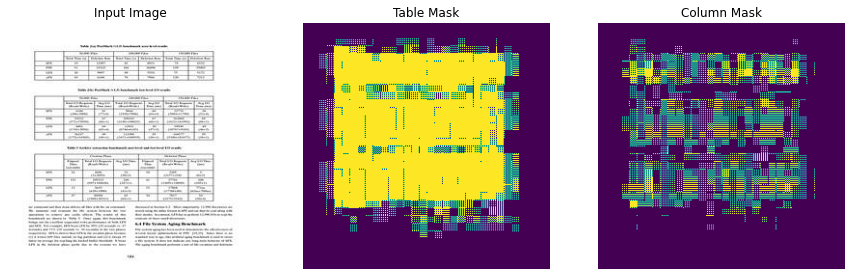

Predicted mask after epoch 1

Epoch 00001: val_loss improved from inf to 0.74372, saving model to /content/drive/My Drive/Colab Notebooks/tablenet_new/model_1
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/tablenet_new/model_1/assets
Epoch 2/200
148/148 [==============================] - 57s 385ms/step - loss: 0.7199 - table_mask_loss: 0.4008 - column_mask_loss: 0.3191 - table_mask_accuracy: 0.8236 - column_mask_accuracy: 0.9428 - val_loss: 0.6447 - val_table_mask_loss: 0.3515 - val_column_mask_loss: 0.2932 - val_table_mask_accuracy: 0.8738 - val_column_mask_accuracy: 0.9777

Epoch 00002: val_loss improved from 0.74372 to 0.64468, saving model to /content/drive/My Drive/Colab Notebooks/tablenet_new/model_2
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/tablenet_new/model_2/assets
Epoch 3/200
148/148 [==============================] - 57s 385ms/step - loss: 0.5997 - table_mask_loss: 0.3505 - column_mask_loss: 0.2491 - table_mask_ac

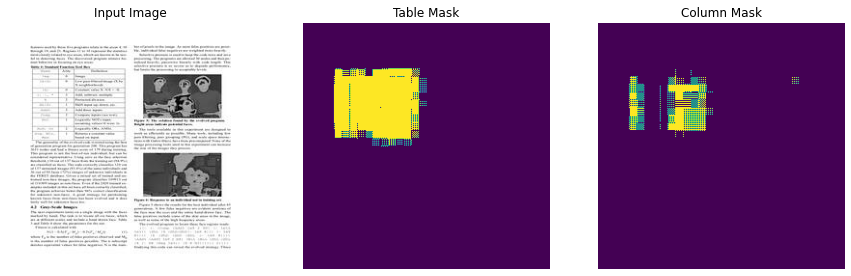

Predicted mask after epoch 11

Epoch 00011: val_loss did not improve from 0.36032
Epoch 12/200
148/148 [==============================] - 56s 376ms/step - loss: 0.3537 - table_mask_loss: 0.2024 - column_mask_loss: 0.1514 - table_mask_accuracy: 0.8212 - column_mask_accuracy: 0.9373 - val_loss: 0.3353 - val_table_mask_loss: 0.2176 - val_column_mask_loss: 0.1177 - val_table_mask_accuracy: 0.8519 - val_column_mask_accuracy: 0.9341

Epoch 00012: val_loss improved from 0.36032 to 0.33531, saving model to /content/drive/My Drive/Colab Notebooks/tablenet_new/model_12
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/tablenet_new/model_12/assets
Epoch 13/200
148/148 [==============================] - 57s 382ms/step - loss: 0.3658 - table_mask_loss: 0.2107 - column_mask_loss: 0.1550 - table_mask_accuracy: 0.8293 - column_mask_accuracy: 0.9313 - val_loss: 0.2791 - val_table_mask_loss: 0.1487 - val_column_mask_loss: 0.1304 - val_table_mask_accuracy: 0.8643 - val_column_mas

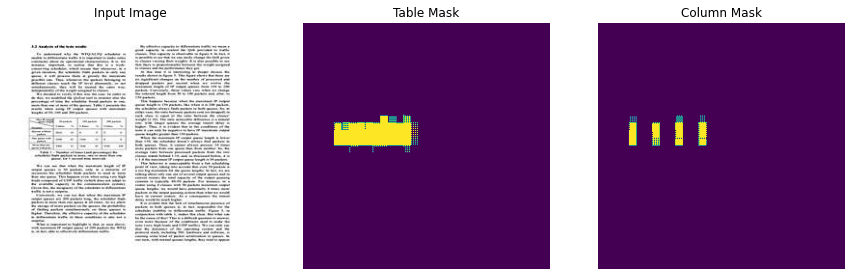

Predicted mask after epoch 21

Epoch 00021: val_loss did not improve from 0.24512
Epoch 22/200
148/148 [==============================] - 56s 376ms/step - loss: 0.2477 - table_mask_loss: 0.1293 - column_mask_loss: 0.1184 - table_mask_accuracy: 0.8228 - column_mask_accuracy: 0.9215 - val_loss: 0.2727 - val_table_mask_loss: 0.1404 - val_column_mask_loss: 0.1324 - val_table_mask_accuracy: 0.8054 - val_column_mask_accuracy: 0.9226

Epoch 00022: val_loss did not improve from 0.24512
Epoch 23/200
148/148 [==============================] - 56s 376ms/step - loss: 0.2636 - table_mask_loss: 0.1426 - column_mask_loss: 0.1210 - table_mask_accuracy: 0.8127 - column_mask_accuracy: 0.9210 - val_loss: 0.3337 - val_table_mask_loss: 0.1566 - val_column_mask_loss: 0.1771 - val_table_mask_accuracy: 0.7914 - val_column_mask_accuracy: 0.9325

Epoch 00023: val_loss did not improve from 0.24512
Epoch 24/200
148/148 [==============================] - 56s 376ms/step - loss: 0.2376 - table_mask_loss: 0.1251 - co

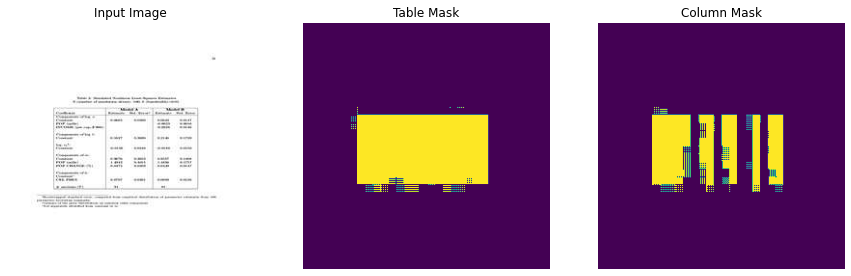

Predicted mask after epoch 31

Epoch 00031: val_loss improved from 0.20610 to 0.20241, saving model to /content/drive/My Drive/Colab Notebooks/tablenet_new/model_31
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/tablenet_new/model_31/assets
Epoch 32/200
148/148 [==============================] - 56s 378ms/step - loss: 0.1937 - table_mask_loss: 0.0902 - column_mask_loss: 0.1035 - table_mask_accuracy: 0.7997 - column_mask_accuracy: 0.9094 - val_loss: 0.2286 - val_table_mask_loss: 0.1429 - val_column_mask_loss: 0.0856 - val_table_mask_accuracy: 0.8473 - val_column_mask_accuracy: 0.9376

Epoch 00032: val_loss did not improve from 0.20241
Epoch 33/200
148/148 [==============================] - 56s 377ms/step - loss: 0.1889 - table_mask_loss: 0.0898 - column_mask_loss: 0.0990 - table_mask_accuracy: 0.8090 - column_mask_accuracy: 0.9155 - val_loss: 0.1944 - val_table_mask_loss: 0.1100 - val_column_mask_loss: 0.0844 - val_table_mask_accuracy: 0.8727 - val_column_mas

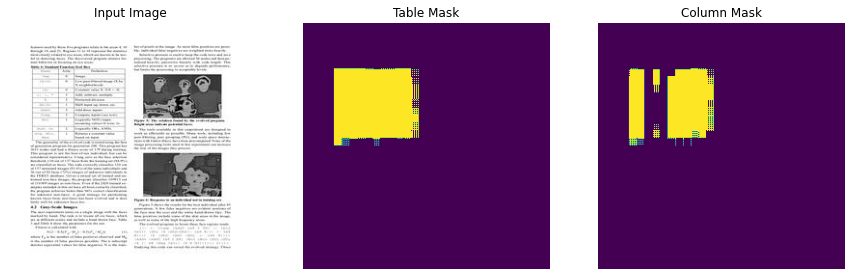

Predicted mask after epoch 41

Epoch 00041: val_loss improved from 0.18849 to 0.18031, saving model to /content/drive/My Drive/Colab Notebooks/tablenet_new/model_41
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/tablenet_new/model_41/assets
Epoch 42/200
148/148 [==============================] - 57s 382ms/step - loss: 0.1550 - table_mask_loss: 0.0645 - column_mask_loss: 0.0905 - table_mask_accuracy: 0.8078 - column_mask_accuracy: 0.9142 - val_loss: 0.1850 - val_table_mask_loss: 0.0859 - val_column_mask_loss: 0.0991 - val_table_mask_accuracy: 0.8290 - val_column_mask_accuracy: 0.9267

Epoch 00042: val_loss did not improve from 0.18031
Epoch 43/200
148/148 [==============================] - 56s 379ms/step - loss: 0.1786 - table_mask_loss: 0.0862 - column_mask_loss: 0.0924 - table_mask_accuracy: 0.8101 - column_mask_accuracy: 0.9213 - val_loss: 0.2303 - val_table_mask_loss: 0.1212 - val_column_mask_loss: 0.1091 - val_table_mask_accuracy: 0.8385 - val_column_mas

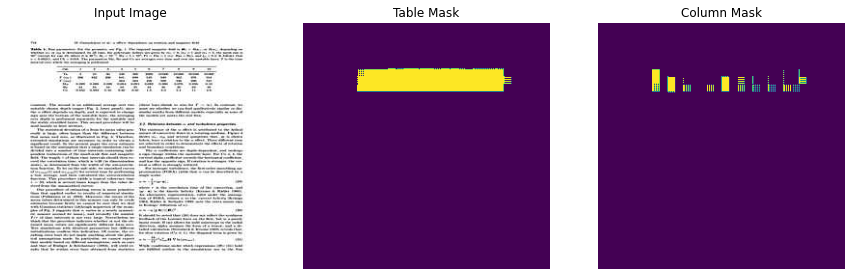

Predicted mask after epoch 51

Epoch 00051: val_loss did not improve from 0.15758
Epoch 52/200
148/148 [==============================] - 56s 376ms/step - loss: 0.1389 - table_mask_loss: 0.0565 - column_mask_loss: 0.0825 - table_mask_accuracy: 0.8172 - column_mask_accuracy: 0.9175 - val_loss: 0.1763 - val_table_mask_loss: 0.1013 - val_column_mask_loss: 0.0750 - val_table_mask_accuracy: 0.8372 - val_column_mask_accuracy: 0.9357

Epoch 00052: val_loss did not improve from 0.15758
Epoch 53/200
148/148 [==============================] - 56s 375ms/step - loss: 0.1391 - table_mask_loss: 0.0578 - column_mask_loss: 0.0813 - table_mask_accuracy: 0.7997 - column_mask_accuracy: 0.9177 - val_loss: 0.1481 - val_table_mask_loss: 0.0735 - val_column_mask_loss: 0.0746 - val_table_mask_accuracy: 0.8362 - val_column_mask_accuracy: 0.9191

Epoch 00053: val_loss improved from 0.15758 to 0.14812, saving model to /content/drive/My Drive/Colab Notebooks/tablenet_new/model_53
INFO:tensorflow:Assets written to

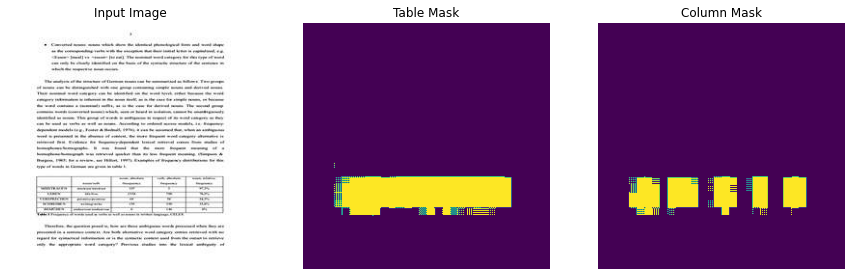

Predicted mask after epoch 61

Epoch 00061: val_loss did not improve from 0.14423
Epoch 62/200
148/148 [==============================] - 55s 375ms/step - loss: 0.1109 - table_mask_loss: 0.0410 - column_mask_loss: 0.0699 - table_mask_accuracy: 0.8230 - column_mask_accuracy: 0.9242 - val_loss: 0.1974 - val_table_mask_loss: 0.1163 - val_column_mask_loss: 0.0811 - val_table_mask_accuracy: 0.8065 - val_column_mask_accuracy: 0.9064

Epoch 00062: val_loss did not improve from 0.14423
Epoch 63/200
148/148 [==============================] - 56s 376ms/step - loss: 0.1183 - table_mask_loss: 0.0422 - column_mask_loss: 0.0761 - table_mask_accuracy: 0.7971 - column_mask_accuracy: 0.9143 - val_loss: 0.1876 - val_table_mask_loss: 0.1198 - val_column_mask_loss: 0.0678 - val_table_mask_accuracy: 0.8184 - val_column_mask_accuracy: 0.9243

Epoch 00063: val_loss did not improve from 0.14423
Epoch 64/200
148/148 [==============================] - 56s 376ms/step - loss: 0.1162 - table_mask_loss: 0.0403 - co

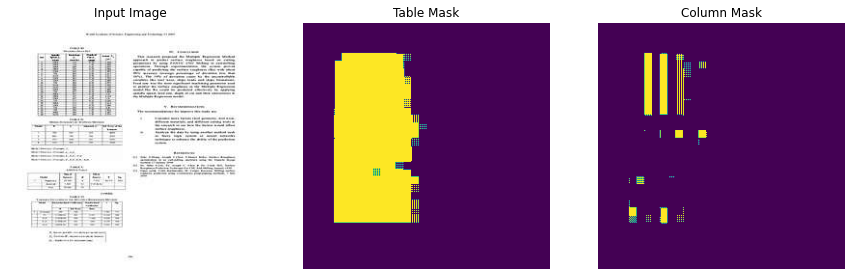

Predicted mask after epoch 71

Epoch 00071: val_loss did not improve from 0.12498
Epoch 72/200
148/148 [==============================] - 56s 379ms/step - loss: 0.0970 - table_mask_loss: 0.0349 - column_mask_loss: 0.0621 - table_mask_accuracy: 0.8215 - column_mask_accuracy: 0.9138 - val_loss: 0.1673 - val_table_mask_loss: 0.1046 - val_column_mask_loss: 0.0627 - val_table_mask_accuracy: 0.8146 - val_column_mask_accuracy: 0.9195

Epoch 00072: val_loss did not improve from 0.12498
Epoch 73/200
148/148 [==============================] - 56s 377ms/step - loss: 0.0944 - table_mask_loss: 0.0333 - column_mask_loss: 0.0611 - table_mask_accuracy: 0.8121 - column_mask_accuracy: 0.9197 - val_loss: 0.1457 - val_table_mask_loss: 0.0762 - val_column_mask_loss: 0.0694 - val_table_mask_accuracy: 0.8126 - val_column_mask_accuracy: 0.9208

Epoch 00073: val_loss did not improve from 0.12498
Epoch 74/200
148/148 [==============================] - 56s 375ms/step - loss: 0.1143 - table_mask_loss: 0.0468 - co

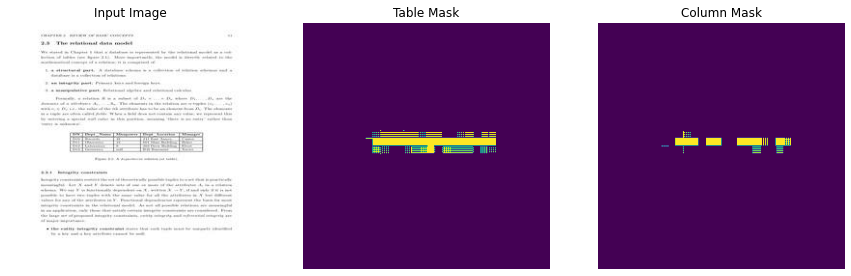

Predicted mask after epoch 81

Epoch 00081: val_loss improved from 0.12498 to 0.11188, saving model to /content/drive/My Drive/Colab Notebooks/tablenet_new/model_81
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/tablenet_new/model_81/assets
Epoch 82/200
148/148 [==============================] - 57s 383ms/step - loss: 0.0893 - table_mask_loss: 0.0339 - column_mask_loss: 0.0554 - table_mask_accuracy: 0.8102 - column_mask_accuracy: 0.9210 - val_loss: 0.1537 - val_table_mask_loss: 0.0934 - val_column_mask_loss: 0.0603 - val_table_mask_accuracy: 0.8086 - val_column_mask_accuracy: 0.9229

Epoch 00082: val_loss did not improve from 0.11188
Epoch 83/200
148/148 [==============================] - 56s 376ms/step - loss: 0.0856 - table_mask_loss: 0.0315 - column_mask_loss: 0.0541 - table_mask_accuracy: 0.8125 - column_mask_accuracy: 0.9167 - val_loss: 0.1549 - val_table_mask_loss: 0.1009 - val_column_mask_loss: 0.0540 - val_table_mask_accuracy: 0.8323 - val_column_mas

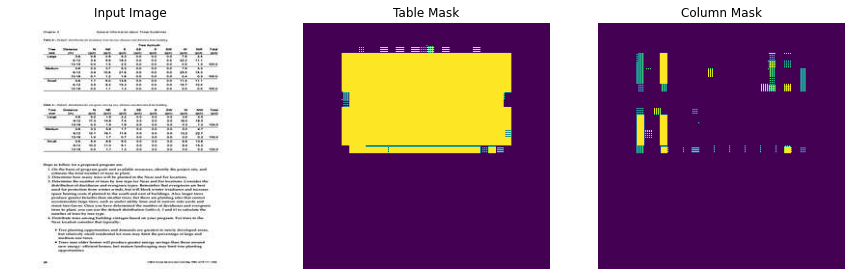

Predicted mask after epoch 91

Epoch 00091: val_loss did not improve from 0.07795
Epoch 92/200
148/148 [==============================] - 56s 378ms/step - loss: 0.0794 - table_mask_loss: 0.0286 - column_mask_loss: 0.0508 - table_mask_accuracy: 0.8114 - column_mask_accuracy: 0.9184 - val_loss: 0.1141 - val_table_mask_loss: 0.0654 - val_column_mask_loss: 0.0486 - val_table_mask_accuracy: 0.8137 - val_column_mask_accuracy: 0.8943

Epoch 00092: val_loss did not improve from 0.07795
Epoch 93/200
148/148 [==============================] - 56s 378ms/step - loss: 0.0770 - table_mask_loss: 0.0268 - column_mask_loss: 0.0502 - table_mask_accuracy: 0.8059 - column_mask_accuracy: 0.9151 - val_loss: 0.1366 - val_table_mask_loss: 0.0896 - val_column_mask_loss: 0.0470 - val_table_mask_accuracy: 0.8386 - val_column_mask_accuracy: 0.9308

Epoch 00093: val_loss did not improve from 0.07795
Epoch 94/200
148/148 [==============================] - 56s 378ms/step - loss: 0.0806 - table_mask_loss: 0.0278 - co

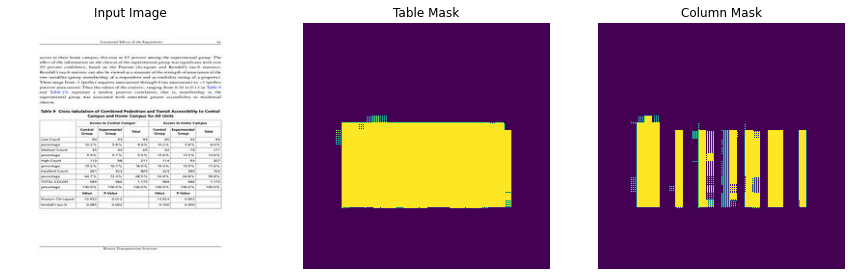

Predicted mask after epoch 101

Epoch 00101: val_loss did not improve from 0.07795
Epoch 102/200
148/148 [==============================] - 56s 377ms/step - loss: 0.0817 - table_mask_loss: 0.0288 - column_mask_loss: 0.0529 - table_mask_accuracy: 0.8060 - column_mask_accuracy: 0.9193 - val_loss: 0.1204 - val_table_mask_loss: 0.0622 - val_column_mask_loss: 0.0582 - val_table_mask_accuracy: 0.8007 - val_column_mask_accuracy: 0.9125

Epoch 00102: val_loss did not improve from 0.07795
Epoch 103/200
148/148 [==============================] - 56s 377ms/step - loss: 0.0766 - table_mask_loss: 0.0262 - column_mask_loss: 0.0504 - table_mask_accuracy: 0.8032 - column_mask_accuracy: 0.9101 - val_loss: 0.0973 - val_table_mask_loss: 0.0559 - val_column_mask_loss: 0.0414 - val_table_mask_accuracy: 0.8491 - val_column_mask_accuracy: 0.9236

Epoch 00103: val_loss did not improve from 0.07795
Epoch 104/200
148/148 [==============================] - 56s 377ms/step - loss: 0.0754 - table_mask_loss: 0.0260 

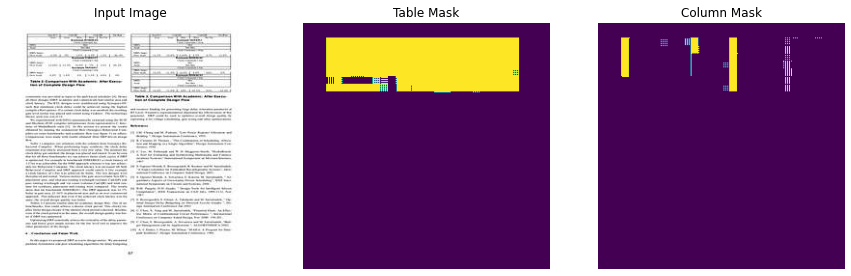

Predicted mask after epoch 111

Epoch 00111: val_loss did not improve from 0.07795
Epoch 112/200
148/148 [==============================] - 55s 375ms/step - loss: 0.0720 - table_mask_loss: 0.0243 - column_mask_loss: 0.0477 - table_mask_accuracy: 0.7950 - column_mask_accuracy: 0.9125 - val_loss: 0.1373 - val_table_mask_loss: 0.0881 - val_column_mask_loss: 0.0492 - val_table_mask_accuracy: 0.8106 - val_column_mask_accuracy: 0.9152

Epoch 00112: val_loss did not improve from 0.07795
Epoch 113/200
148/148 [==============================] - 55s 375ms/step - loss: 0.0687 - table_mask_loss: 0.0250 - column_mask_loss: 0.0438 - table_mask_accuracy: 0.8023 - column_mask_accuracy: 0.9156 - val_loss: 0.0632 - val_table_mask_loss: 0.0296 - val_column_mask_loss: 0.0336 - val_table_mask_accuracy: 0.8723 - val_column_mask_accuracy: 0.9302

Epoch 00113: val_loss improved from 0.07795 to 0.06317, saving model to /content/drive/My Drive/Colab Notebooks/tablenet_new/model_113
INFO:tensorflow:Assets writte

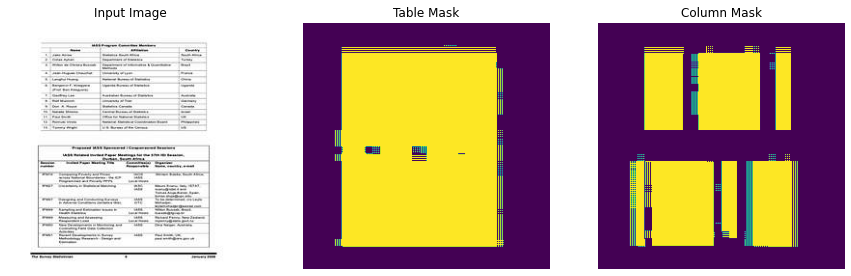

Predicted mask after epoch 121

Epoch 00121: val_loss did not improve from 0.06317
Epoch 122/200
148/148 [==============================] - 56s 375ms/step - loss: 0.0637 - table_mask_loss: 0.0216 - column_mask_loss: 0.0421 - table_mask_accuracy: 0.8105 - column_mask_accuracy: 0.9183 - val_loss: 0.0920 - val_table_mask_loss: 0.0538 - val_column_mask_loss: 0.0382 - val_table_mask_accuracy: 0.8482 - val_column_mask_accuracy: 0.9254

Epoch 00122: val_loss did not improve from 0.06317
Epoch 123/200
148/148 [==============================] - 55s 375ms/step - loss: 0.0610 - table_mask_loss: 0.0209 - column_mask_loss: 0.0400 - table_mask_accuracy: 0.8133 - column_mask_accuracy: 0.9171 - val_loss: 0.1145 - val_table_mask_loss: 0.0738 - val_column_mask_loss: 0.0407 - val_table_mask_accuracy: 0.8215 - val_column_mask_accuracy: 0.9183

Epoch 00123: val_loss did not improve from 0.06317
Epoch 124/200
148/148 [==============================] - 56s 375ms/step - loss: 0.0751 - table_mask_loss: 0.0308 

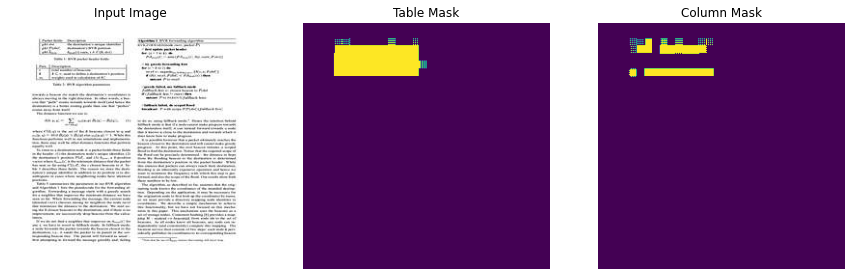

Predicted mask after epoch 131

Epoch 00131: val_loss did not improve from 0.06317
Epoch 132/200
148/148 [==============================] - 56s 377ms/step - loss: 0.0564 - table_mask_loss: 0.0192 - column_mask_loss: 0.0372 - table_mask_accuracy: 0.8172 - column_mask_accuracy: 0.9184 - val_loss: 0.1370 - val_table_mask_loss: 0.0886 - val_column_mask_loss: 0.0484 - val_table_mask_accuracy: 0.7865 - val_column_mask_accuracy: 0.9081

Epoch 00132: val_loss did not improve from 0.06317
Epoch 133/200
148/148 [==============================] - 56s 376ms/step - loss: 0.0640 - table_mask_loss: 0.0213 - column_mask_loss: 0.0427 - table_mask_accuracy: 0.7866 - column_mask_accuracy: 0.9153 - val_loss: 0.1481 - val_table_mask_loss: 0.1126 - val_column_mask_loss: 0.0355 - val_table_mask_accuracy: 0.8507 - val_column_mask_accuracy: 0.9374

Epoch 00133: val_loss did not improve from 0.06317
Epoch 134/200
148/148 [==============================] - 56s 377ms/step - loss: 0.0553 - table_mask_loss: 0.0182 

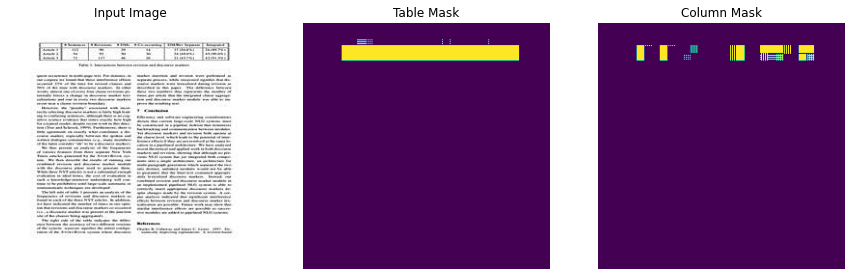

Predicted mask after epoch 141

Epoch 00141: val_loss did not improve from 0.06317
Epoch 142/200
148/148 [==============================] - 56s 378ms/step - loss: 0.0551 - table_mask_loss: 0.0182 - column_mask_loss: 0.0369 - table_mask_accuracy: 0.8057 - column_mask_accuracy: 0.9148 - val_loss: 0.1087 - val_table_mask_loss: 0.0758 - val_column_mask_loss: 0.0329 - val_table_mask_accuracy: 0.8474 - val_column_mask_accuracy: 0.9242

Epoch 00142: val_loss did not improve from 0.06317
Epoch 143/200
148/148 [==============================] - 56s 376ms/step - loss: 0.0523 - table_mask_loss: 0.0180 - column_mask_loss: 0.0343 - table_mask_accuracy: 0.8278 - column_mask_accuracy: 0.9254 - val_loss: 0.1082 - val_table_mask_loss: 0.0726 - val_column_mask_loss: 0.0355 - val_table_mask_accuracy: 0.8373 - val_column_mask_accuracy: 0.9270

Epoch 00143: val_loss did not improve from 0.06317
Epoch 144/200
148/148 [==============================] - 56s 378ms/step - loss: 0.0550 - table_mask_loss: 0.0188 

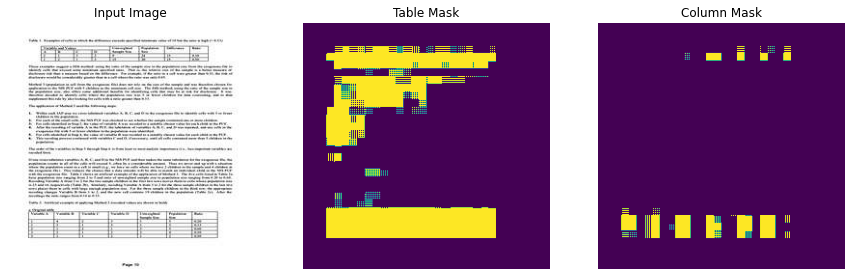

Predicted mask after epoch 151

Epoch 00151: val_loss did not improve from 0.06131
Epoch 152/200
148/148 [==============================] - 56s 377ms/step - loss: 0.0542 - table_mask_loss: 0.0173 - column_mask_loss: 0.0369 - table_mask_accuracy: 0.8087 - column_mask_accuracy: 0.9123 - val_loss: 0.1228 - val_table_mask_loss: 0.0910 - val_column_mask_loss: 0.0318 - val_table_mask_accuracy: 0.8176 - val_column_mask_accuracy: 0.9119

Epoch 00152: val_loss did not improve from 0.06131
Epoch 153/200
148/148 [==============================] - 56s 377ms/step - loss: 0.0541 - table_mask_loss: 0.0188 - column_mask_loss: 0.0353 - table_mask_accuracy: 0.8050 - column_mask_accuracy: 0.9176 - val_loss: 0.1295 - val_table_mask_loss: 0.0925 - val_column_mask_loss: 0.0370 - val_table_mask_accuracy: 0.8197 - val_column_mask_accuracy: 0.9210

Epoch 00153: val_loss did not improve from 0.06131
Epoch 154/200
148/148 [==============================] - 56s 377ms/step - loss: 0.0555 - table_mask_loss: 0.0196 

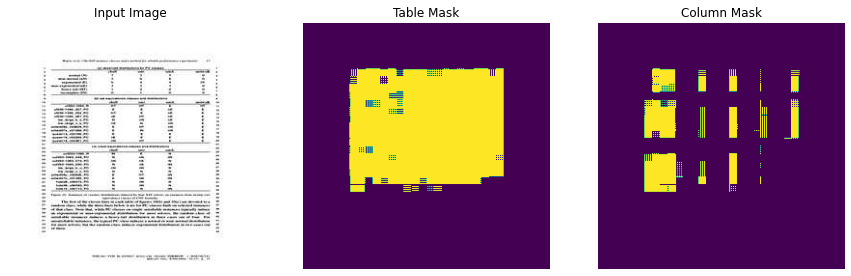

Predicted mask after epoch 161

Epoch 00161: val_loss did not improve from 0.06131
Epoch 162/200
148/148 [==============================] - 56s 377ms/step - loss: 0.0780 - table_mask_loss: 0.0290 - column_mask_loss: 0.0490 - table_mask_accuracy: 0.8150 - column_mask_accuracy: 0.9208 - val_loss: 0.1545 - val_table_mask_loss: 0.1123 - val_column_mask_loss: 0.0422 - val_table_mask_accuracy: 0.8379 - val_column_mask_accuracy: 0.9321

Epoch 00162: val_loss did not improve from 0.06131
Epoch 163/200
148/148 [==============================] - 56s 377ms/step - loss: 0.0620 - table_mask_loss: 0.0229 - column_mask_loss: 0.0391 - table_mask_accuracy: 0.8096 - column_mask_accuracy: 0.9220 - val_loss: 0.0942 - val_table_mask_loss: 0.0599 - val_column_mask_loss: 0.0343 - val_table_mask_accuracy: 0.8395 - val_column_mask_accuracy: 0.9155

Epoch 00163: val_loss did not improve from 0.06131
Epoch 164/200
148/148 [==============================] - 56s 377ms/step - loss: 0.0576 - table_mask_loss: 0.0189 

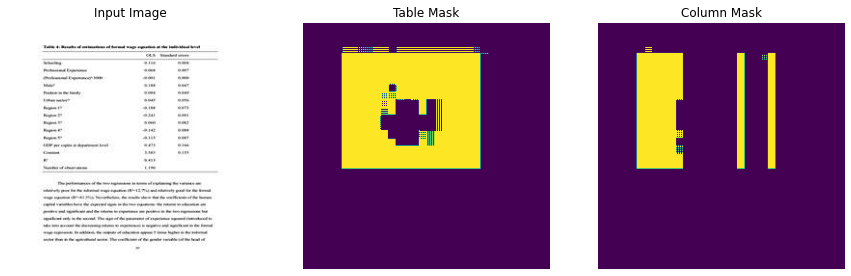

Predicted mask after epoch 171

Epoch 00171: val_loss did not improve from 0.06131
Epoch 172/200
148/148 [==============================] - 56s 377ms/step - loss: 0.0515 - table_mask_loss: 0.0160 - column_mask_loss: 0.0355 - table_mask_accuracy: 0.8005 - column_mask_accuracy: 0.9082 - val_loss: 0.0976 - val_table_mask_loss: 0.0636 - val_column_mask_loss: 0.0339 - val_table_mask_accuracy: 0.8418 - val_column_mask_accuracy: 0.9250

Epoch 00172: val_loss did not improve from 0.06131
Epoch 173/200
148/148 [==============================] - 56s 377ms/step - loss: 0.0494 - table_mask_loss: 0.0166 - column_mask_loss: 0.0328 - table_mask_accuracy: 0.8096 - column_mask_accuracy: 0.9199 - val_loss: 0.1604 - val_table_mask_loss: 0.1245 - val_column_mask_loss: 0.0359 - val_table_mask_accuracy: 0.8168 - val_column_mask_accuracy: 0.9148

Epoch 00173: val_loss did not improve from 0.06131
Epoch 174/200
148/148 [==============================] - 56s 377ms/step - loss: 0.0496 - table_mask_loss: 0.0163 

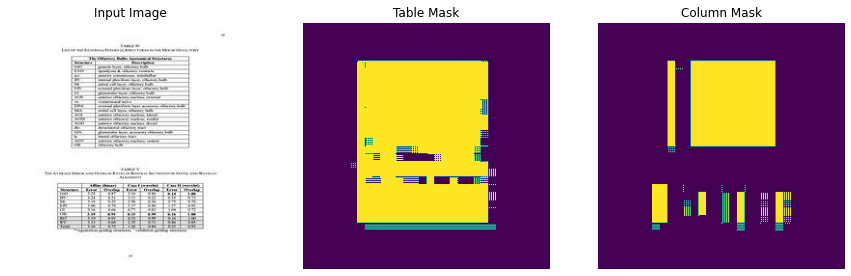

Predicted mask after epoch 181

Epoch 00181: val_loss did not improve from 0.06131
Epoch 182/200
148/148 [==============================] - 56s 378ms/step - loss: 0.0492 - table_mask_loss: 0.0162 - column_mask_loss: 0.0330 - table_mask_accuracy: 0.8073 - column_mask_accuracy: 0.9203 - val_loss: 0.1053 - val_table_mask_loss: 0.0674 - val_column_mask_loss: 0.0379 - val_table_mask_accuracy: 0.8074 - val_column_mask_accuracy: 0.9107

Epoch 00182: val_loss did not improve from 0.06131
Epoch 183/200
148/148 [==============================] - 56s 377ms/step - loss: 0.0501 - table_mask_loss: 0.0160 - column_mask_loss: 0.0341 - table_mask_accuracy: 0.7980 - column_mask_accuracy: 0.9043 - val_loss: 0.1550 - val_table_mask_loss: 0.1249 - val_column_mask_loss: 0.0301 - val_table_mask_accuracy: 0.8392 - val_column_mask_accuracy: 0.9290

Epoch 00183: val_loss did not improve from 0.06131
Epoch 184/200
148/148 [==============================] - 56s 377ms/step - loss: 0.0515 - table_mask_loss: 0.0163 

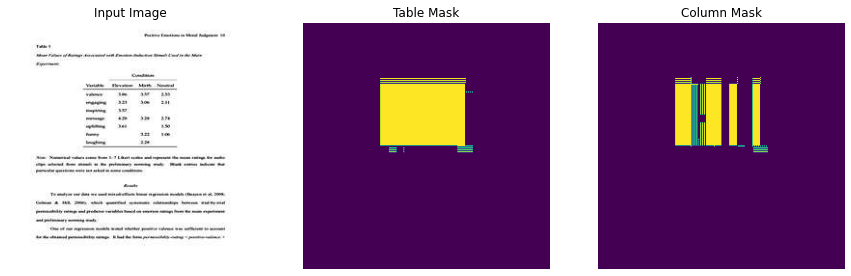

Predicted mask after epoch 191

Epoch 00191: val_loss did not improve from 0.06131
Epoch 192/200
148/148 [==============================] - 56s 377ms/step - loss: 0.0480 - table_mask_loss: 0.0161 - column_mask_loss: 0.0319 - table_mask_accuracy: 0.8115 - column_mask_accuracy: 0.9161 - val_loss: 0.1006 - val_table_mask_loss: 0.0630 - val_column_mask_loss: 0.0376 - val_table_mask_accuracy: 0.7752 - val_column_mask_accuracy: 0.8886

Epoch 00192: val_loss did not improve from 0.06131
Epoch 193/200
148/148 [==============================] - 56s 377ms/step - loss: 0.0501 - table_mask_loss: 0.0163 - column_mask_loss: 0.0338 - table_mask_accuracy: 0.8026 - column_mask_accuracy: 0.9122 - val_loss: 0.1464 - val_table_mask_loss: 0.1183 - val_column_mask_loss: 0.0281 - val_table_mask_accuracy: 0.8441 - val_column_mask_accuracy: 0.9270

Epoch 00193: val_loss did not improve from 0.06131
Epoch 194/200
148/148 [==============================] - 56s 378ms/step - loss: 0.0453 - table_mask_loss: 0.0145 

In [ ]:
VALIDATION_STEPS = VALIDATION_SIZE//BATCH_SIZE
model_history = model.fit(train_data, epochs=200,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=validation_data, callbacks = [ShowPredictionCallback(), model_checkpoint])
#model.save_weights(os.path.join(path, '120_epoch.h5'))

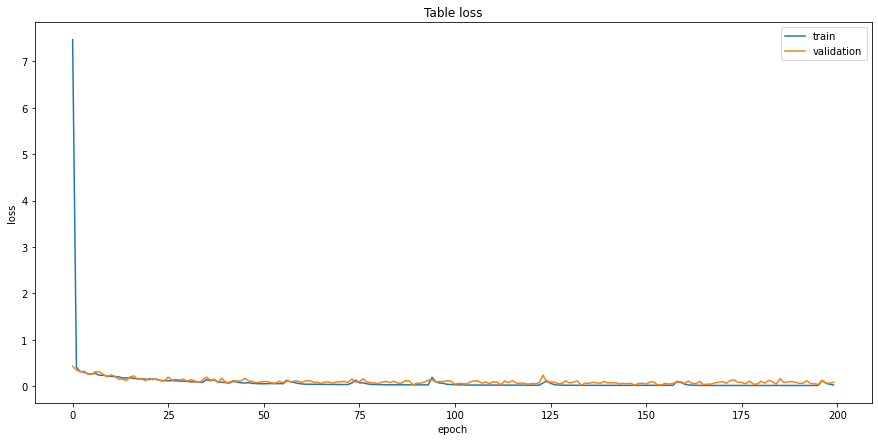

In [ ]:
plt.figure(figsize = (15,7))
plt.plot(model_history.history['table_mask_loss'])
plt.plot(model_history.history['val_table_mask_loss'])
plt.title('Table loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','validation'])
plt.show()

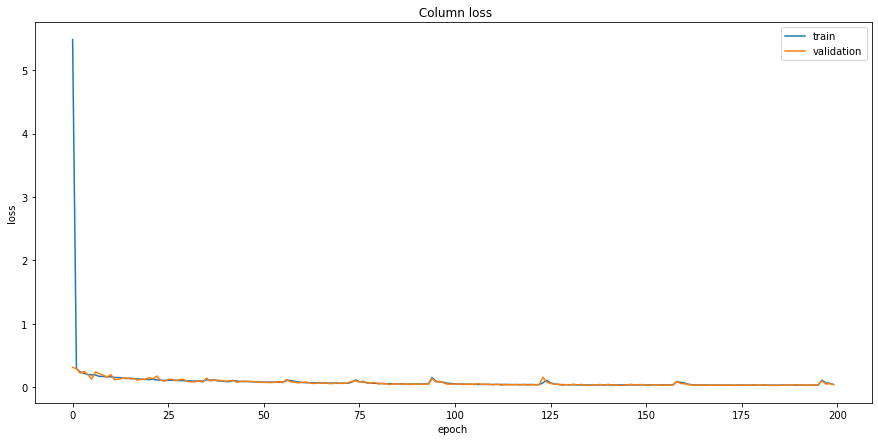

In [ ]:
plt.figure(figsize = (15,7))
plt.plot(model_history.history['column_mask_loss'])
plt.plot(model_history.history['val_column_mask_loss'])
plt.title(' Column loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','validation'])
plt.show()

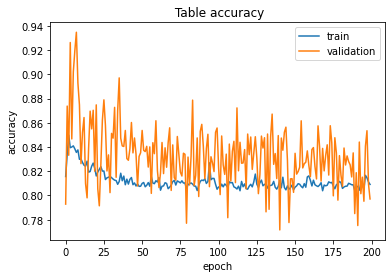

In [ ]:
#plt.figure(figsize = (5,5))
plt.plot(model_history.history['table_mask_accuracy'])
plt.plot(model_history.history['val_table_mask_accuracy'])
plt.title(' Table accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','validation'])
plt.show()

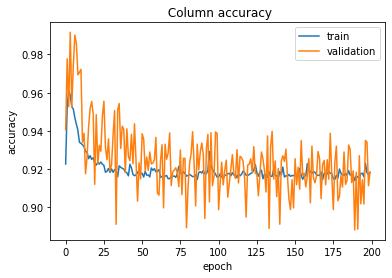

In [ ]:
plt.plot(model_history.history['column_mask_accuracy'])
plt.plot(model_history.history['val_column_mask_accuracy'])
plt.title(' Column accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','validation'])
plt.show()

Let us now take some random images from validation data and see the prdictions

In [ ]:
model = load_model('/content/drive/MyDrive/Colab Notebooks/tablenet_new/model_148')

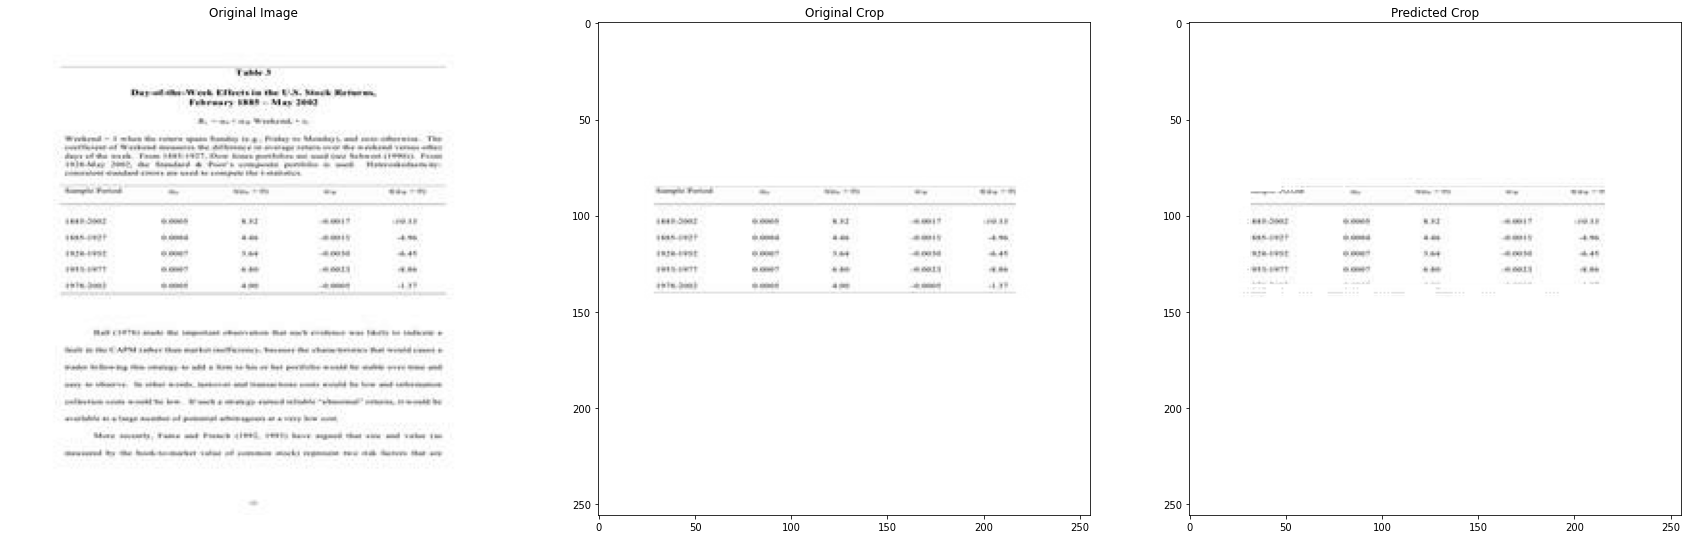

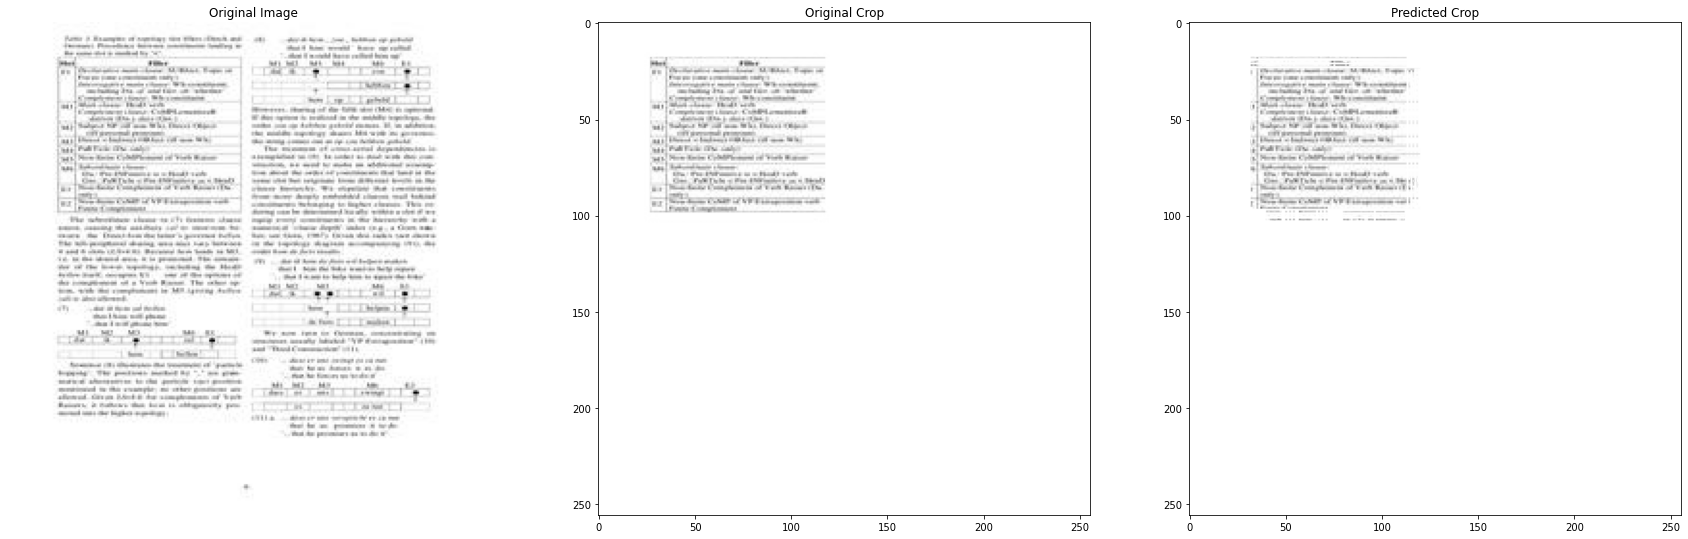

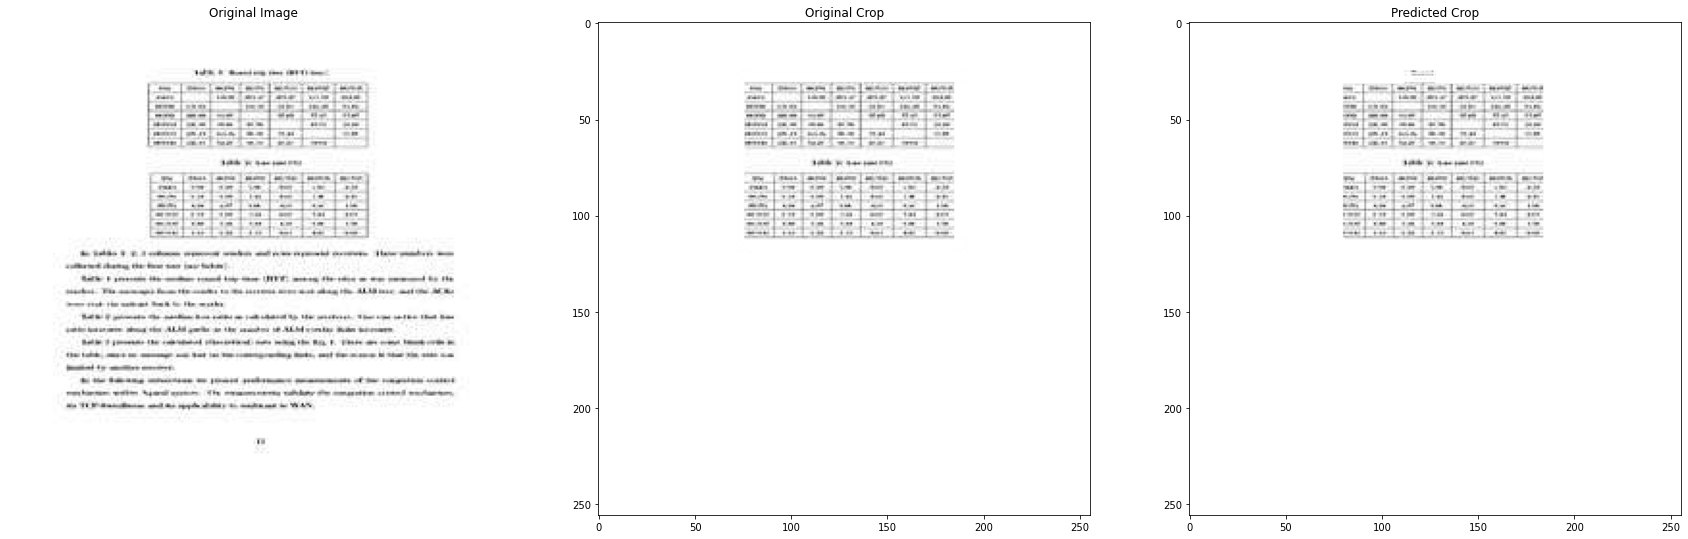

In [ ]:
num = 3
for image,mask in validation.take(num):
  plt.figure(figsize = (30,50))

  table_mask = mask['table_mask']
  table_mask = tf.keras.preprocessing.image.array_to_img(table_mask)
  #plt.imshow(table_mask)

  column_mask = mask['column_mask']
  column_mask = tf.keras.preprocessing.image.array_to_img(column_mask)
  plt.imshow(column_mask)

  pred_mask1, pred_mask2 = model.predict(image[np.newaxis,:,:,:])
  pred_tabmask = tf.argmax(pred_mask1, axis=-1)
  pred_tabmask = pred_tabmask[..., tf.newaxis]
  pred_colmask = tf.argmax(pred_mask2, axis=-1)
  pred_colmask = pred_colmask[..., tf.newaxis]
  pred_table_mask = pred_tabmask[0]
  pred_column_mask = pred_colmask[0]

  pred_table_mask = tf.keras.preprocessing.image.array_to_img(pred_table_mask)
  pred_column_mask = tf.keras.preprocessing.image.array_to_img(pred_column_mask)

  title = ['Original Image', 'Original Crop', 'Predicted Crop']
  for i in range(len(title)):
    plt.subplot(1,len(title), i+1)
    if i==0:
      plt.title(title[i])
      plt.imshow(tf.keras.preprocessing.image.array_to_img(image))
      plt.axis('off')
    elif i==1:
      plt.title(title[i])
      img = tf.keras.preprocessing.image.array_to_img(image)
      img.putalpha(table_mask)
      plt.imshow(tf.keras.preprocessing.image.array_to_img(img))

    elif i==2:
      plt.title(title[i])
      img = tf.keras.preprocessing.image.array_to_img(image)
      img.putalpha(pred_table_mask)
      plt.imshow(tf.keras.preprocessing.image.array_to_img(img))
  plt.show()

Let us now take a sample image and convert the table data into text

In [ ]:
! apt install tesseract-ocr
! apt install libtesseract-dev

In [ ]:
! pip install Pillow
! pip install pytesseract

In [ ]:
!sudo apt install tesseract-ocr

In [ ]:
import pytesseract
from PIL import ImageEnhance, ImageFilter, Image

In [ ]:
pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'

In [ ]:
!wget --header="Host: doc-0o-3o-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.212 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Cookie: AUTH_sdg3i7v4ri7e38pdfprsctq13ekkc1am_nonce=ot15dp08pcaaa" --header="Connection: keep-alive" "https://doc-0o-3o-docs.googleusercontent.com/docs/securesc/c7h9tlgpbqilf9nmomrdtg90qdn0nlc3/8u8v2v9gejv3ugib5uv9gt2bf4qfk042/1621942725000/00048055783660299439/13937806133259344158/1Ms3h7oNoWZxR0nnW_1D_Vq9F254wqSXp?e=download&authuser=0&nonce=ot15dp08pcaaa&user=13937806133259344158&hash=cq072fk0vcac6u0trg4nd97shuapjp5f" -c -O 'Marmot_data.zip'

--2021-05-25 11:39:19--  https://doc-0o-3o-docs.googleusercontent.com/docs/securesc/c7h9tlgpbqilf9nmomrdtg90qdn0nlc3/8u8v2v9gejv3ugib5uv9gt2bf4qfk042/1621942725000/00048055783660299439/13937806133259344158/1Ms3h7oNoWZxR0nnW_1D_Vq9F254wqSXp?e=download&authuser=0&nonce=ot15dp08pcaaa&user=13937806133259344158&hash=cq072fk0vcac6u0trg4nd97shuapjp5f
Resolving doc-0o-3o-docs.googleusercontent.com (doc-0o-3o-docs.googleusercontent.com)... 172.253.117.132, 2607:f8b0:400e:c0a::84
Connecting to doc-0o-3o-docs.googleusercontent.com (doc-0o-3o-docs.googleusercontent.com)|172.253.117.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘Marmot_data.zip’

Marmot_data.zip         [   <=>              ]  65.63M   102MB/s    in 0.6s    

2021-05-25 11:39:20 (102 MB/s) - ‘Marmot_data.zip’ saved [68820548]



In [ ]:
!unzip Marmot_data.zip

 

 

   

| Spies Representative Platforms ——Taeriace | Pig ncal an Socal comeaians, norma
‘ie sapab ice
Stan ae Copan eal poe

 

 

 

 

 

Senter
mally, it must be noted that the configuration of Figure I may also concer a single organizatio
here cach coment (depicted with an octagon) involves intra-organization activities.

 

 

Socially Deliberating Age

 

le 2 presents the al

 

\es that representative and assistant agents must have to deliberate socially,

‘Table 2. Requirements from the representative and assistant agents,

 

 

 

ipresentathve agent “Avsistant agent
Asnagenent of knowledge aboot People Machine ae Ttonsgement of knowlsdge aboan Onan a
Nogorstton stnecs| = CSIRRSESIRS ecto mating. plans

 

 



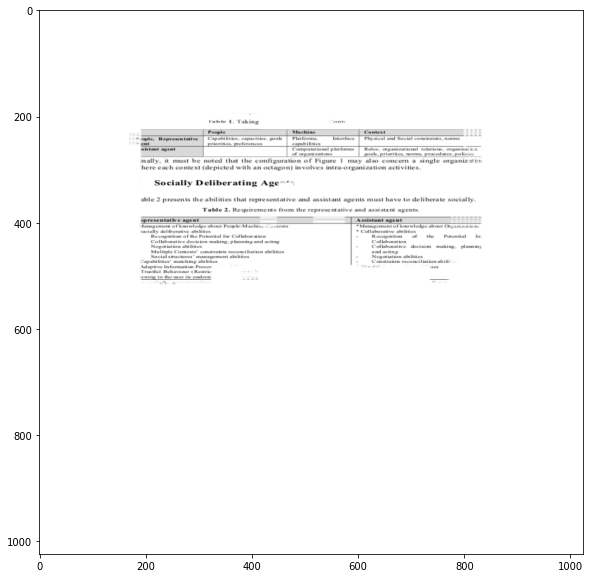

In [ ]:
img = cv2.imread('/content/10.1.1.1.2043_4.bmp')
img = cv2.resize(img,(1024,1024), cv2.INTER_AREA)
img_256 = cv2.resize(img,(256,256), cv2.INTER_NEAREST)
img_256.shape
if img_256.shape[2] == 4:
  img_256 = cv2.cvtColor(img_256, cv2.COLOR_RGBA2RGB)
elif img_256.shape[2] == 1:
  img_256 = cv2.cvtColor(img_256, cv2.COLOR_GRAY2RGB)
else:
  img_256 = cv2.cvtColor(img_256, cv2.COLOR_BGR2RGB)
img_256 = np.expand_dims(img_256, axis = 0)
#print(img_256.shape)
pred_mask1, pred_mask2 = model.predict(img_256)

pred_tabmask = tf.argmax(pred_mask1, axis=-1)
pred_tabmask = pred_tabmask[..., tf.newaxis]
pred_colmask = tf.argmax(pred_mask2, axis=-1)
pred_colmask = pred_colmask[..., tf.newaxis]
pred_table_mask = pred_tabmask[0]
pred_column_mask = pred_colmask[0]
#print(pred_table_mask.shape)
pred_table_mask = tf.keras.preprocessing.image.array_to_img(pred_table_mask)
#print(pred_table_mask.size)
pred_column_mask = tf.keras.preprocessing.image.array_to_img(pred_column_mask)
#print(pred_column_mask.size)
#print(type(pred_table_mask))
pred_table_mask = cv2.resize(np.array(pred_table_mask), (1024,1024), cv2.INTER_NEAREST)
#print(type(pred_table_mask))
pred_column_mask = cv2.resize(np.array(pred_column_mask), (1024,1024), cv2.INTER_NEAREST)
pred_table_mask = tf.keras.preprocessing.image.array_to_img(pred_table_mask[:,:,np.newaxis])
#print(pred_table_mask.size)
pred_column_mask = tf.keras.preprocessing.image.array_to_img(pred_column_mask[:,:,np.newaxis])
img = tf.keras.preprocessing.image.array_to_img(img)

img.putalpha(pred_table_mask)
text = pytesseract.image_to_string(img)
print(text)
plt.figure(figsize = (10,10))
plt.imshow(img)